In [33]:
#Check if dataset loads

import csv
import os
import numpy as np
import cv2
import keras

DATASET_PATH = "../../data/udacity_sim_data/"
VAL_PATH = "../../data/track2/seq1/"
def load_dataset(file_path):
    '''
    Loads dataset in memory
    '''
    dataset = []
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            try:
                dataset.append({'center':line[0], 'left':line[1], 'right':line[2], 'steering':float(line[3]), 
                            'throttle':float(line[4]), 'brake':float(line[5]), 'speed':float(line[6])})
            except:
                continue
    return dataset

dataset = load_dataset(os.path.join(DATASET_PATH, "driving_log.csv"))
val_dataset = load_dataset(os.path.join(VAL_PATH, "driving_log.csv"))

print("Loaded {} samples from file {}".format(len(dataset),DATASET_PATH))
print("Loaded {} samples from file {}".format(len(val_dataset),VAL_PATH))

Loaded 45999 samples from file ../../data/udacity_sim_data/
Loaded 1328 samples from file ../../data/track2/seq1/


NameError: name 'plot_dataset_histogram' is not defined

In [34]:
#Partion the dataset

import random
from sklearn.model_selection import train_test_split

random.shuffle(dataset)

#train_set, test_set = train_test_split(dataset, test_size=0.05)

train_set, valid_set = train_test_split(dataset, test_size=0.20)

print("train set has {} elements".format(len(train_set)))
#print("test set has {} elements".format(len(test_set)))
print("validation set has {} elements".format(len(valid_set)))

# For validation on new track. Overwriting here
valid_set = val_dataset
print("validation set has {} elements".format(len(valid_set)))

train set has 36799 elements
validation set has 9200 elements
validation set has 1328 elements


In [35]:
# Dataset Augmentation

import cv2
import numpy as np
from keras.preprocessing.image import *

def image_preprocessing(img):
    """preproccesing training data to keep only S channel in HSV color space, and resize to 16X32"""

    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(320, 160))
    return resized

def flip_horizontal(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

def channel_shift(image, steering_angle, intensity=20, channel_axis=2):
    channeled_image = random_channel_shift(image, intensity, channel_axis)
    return channeled_image, steering_angle

def random_transform(image, steering_angle):
    image = image_preprocessing(image)
    if np.random.random() < 0.5:
        image, steering_angle = flip_horizontal(image, steering_angle)
    
    #image, steering_angle = channel_shift(image, steering_angle)

    return image, steering_angle

(160, 320)


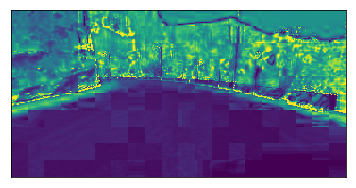

In [36]:
import matplotlib.pyplot as plt
BATCH_SIZE = 128

sample_file = os.path.join(DATASET_PATH, dataset[0]['center'].strip())
#INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS = cv2.imread(sample_file).shape[:3]
INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS = 160, 320, 1

def load_and_augment_image(path, image_data, side_camera_offset=0.30):
    
    index = np.random.randint(3)
    
    if index == 0:
        image_file = os.path.join(path, image_data['left'].strip())
        angle_offset = side_camera_offset
    elif index == 1:
        image_file = os.path.join(path, image_data['center'].strip())
        angle_offset = 0.
    elif index == 2:
        image_file = os.path.join(path, image_data['right'].strip())
        angle_offset = - side_camera_offset
    
    steering_angle = image_data['steering'] + angle_offset
    #steering_angle = image_data['steering']
    #image_file = os.path.join(DATASET_PATH, image_data['center'].strip())
    image = cv2.imread(image_file)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image, steering_angle = random_transform(image, steering_angle)
    return image, steering_angle


augmented_steering_angles = []
train_image_index = 0

def train_generate_batch_data(dataset, batch_size=BATCH_SIZE):
    
    global augmented_steering_angles
    global train_image_index

    batch_images = np.zeros((batch_size, INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS))
    batch_steering_angles = np.zeros(batch_size)

    while 1:
        for batch_index in range(batch_size):

            #image_index = np.random.randint(len(dataset))
            if train_image_index >= len(dataset):
                train_image_index = 0
            image_data = dataset[train_image_index]

            try:
                image, steering_angle = load_and_augment_image(DATASET_PATH, image_data)
                augmented_steering_angles.append(steering_angle)
                batch_images[batch_index] = image.reshape([160, 320, 1])
                batch_steering_angles[batch_index] = steering_angle
                train_image_index = train_image_index + 1

            except:
                continue

        yield batch_images, batch_steering_angles
        
        
        
valid_image_index = 0

def valid_generate_batch_data(dataset, batch_size=BATCH_SIZE):
    global valid_image_index

    batch_images = np.zeros((batch_size, INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS))
    batch_steering_angles = np.zeros(batch_size)

    while 1:
        for batch_index in range(batch_size):

            #image_index = np.random.randint(len(dataset))
            if valid_image_index >= len(dataset):
                valid_image_index = 0
            image_data = dataset[valid_image_index]

            try:
                image, steering_angle = load_and_augment_image(VAL_PATH, image_data)
                batch_images[batch_index] = image.reshape([160, 320, 1])
                batch_steering_angles[batch_index] = steering_angle
                valid_image_index = valid_image_index + 1

            except:
                continue

        yield batch_images, batch_steering_angles


image, _ = load_and_augment_image(VAL_PATH, valid_set[0])

print(image.shape)

plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
sample_gen = valid_generate_batch_data(valid_set)
for i in range(10):
    next(sample_gen)
#plot_steering_histogram(augmented_steering_angles, "augmented_data", num_bins=50)


In [ ]:
# validation dataset

# for image_data in valid_set:
#     image, steering_angle = load_and_augment_image(image_data)
#     X_valid.append(image)
#     Y_valid.append(steering_angle)

In [37]:
from keras.models import Sequential, Model
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam

print("\nBuilding and compiling the model ...")

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS)))
# Block - conv
model.add(Convolution2D(1, 11, 11, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv1'))
# Block - conv
model.add(Convolution2D(1, 5, 5, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv2'))
# Block - conv
#model.add(Convolution2D(1, 3, 3, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv3'))
# Block - conv
#model.add(Convolution2D(1, 3, 3, border_mode='valid', init='glorot_uniform', activation='relu', name='Conv4'))
# Block - flatten
#model.add(MaxPooling2D((4,4),(4,4),'valid', name='pool1'))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(1, name='output')) 
model.summary()

#adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 160, 320, 1)   0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 75, 155, 1)    122         lambda_5[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 36, 76, 1)     26          Conv1[0][0]                      
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 36, 76, 1)     0           Conv2[0][0]                      
_____________________________________________________

In [38]:
AUGMENTATION_FACTOR = 1
NUM_EPOCHS = 10

import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        pass
    
    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')

        
def compute_samples_per_epoch(array_size, batch_size):
    num_batches = math.ceil(array_size / batch_size)
    samples_per_epoch = num_batches * batch_size
    return samples_per_epoch

lifecycle_callback = LifeCycleCallBack()
tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_only/', histogram_freq=1, 
                                          write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_only/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)



train_generator = train_generate_batch_data(train_set, BATCH_SIZE)
valid_generator = valid_generate_batch_data(valid_set, BATCH_SIZE)

samples_per_epoch = compute_samples_per_epoch((len(train_set)*AUGMENTATION_FACTOR), BATCH_SIZE) 
nb_val_samples = compute_samples_per_epoch((len(valid_set)*AUGMENTATION_FACTOR), BATCH_SIZE) 
 
history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              samples_per_epoch = samples_per_epoch, 
                              nb_val_samples = nb_val_samples,
                              nb_epoch = NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, checkpoint])

print("\nTraining the model ended.")

print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("../../data/weights/steer_only/model.h5")
print("Model Saved.")

Beginning training
Epoch 1/10
36864/36864 [==============================] - 44s - loss: 0.0520 - val_loss: 0.0458
Epoch 2/10
36864/36864 [==============================] - 43s - loss: 0.0278 - val_loss: 0.0347
Epoch 3/10
36864/36864 [==============================] - 43s - loss: 0.0245 - val_loss: 0.0340
Epoch 4/10
36864/36864 [==============================] - 43s - loss: 0.0231 - val_loss: 0.0338
Epoch 5/10
36864/36864 [==============================] - 43s - loss: 0.0232 - val_loss: 0.0339
Epoch 6/10
36864/36864 [==============================] - 43s - loss: 0.0220 - val_loss: 0.0316
Epoch 7/10
36864/36864 [==============================] - 43s - loss: 0.0224 - val_loss: 0.0290
Epoch 8/10
36864/36864 [==============================] - 43s - loss: 0.0216 - val_loss: 0.0289
Epoch 9/10
36864/36864 [==============================] - 43s - loss: 0.0215 - val_loss: 0.0284
Epoch 10/10
36864/36864 [==============================] - 43s - loss: 0.0207 - val_loss: 0.0337
Ending Training

Tra

In [16]:
model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("../../data/weights/steer_only/model.h5")
print("Model Saved.")

Model Saved.


Convolutional features shape:  (1, 75, 155, 1)


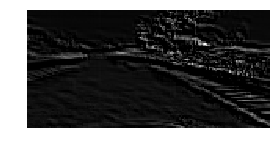

Convolutional features shape:  (1, 36, 76, 1)


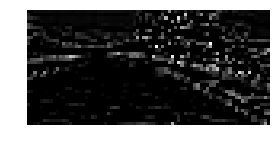

In [42]:
##Visualization of the convolutional layers
from keras.models import load_model, Model
from keras.models import model_from_json
import cv2
import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = "../../data/weights/steer_only/model.json"
test_file = os.path.join(DATASET_PATH, dataset[0]['center'])
 
def visualize_model_layer_output(model, layer_name, image_file):
    test_model = Model(input=model.input, output=model.get_layer(layer_name).output)
 
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 1]
    image_array = np.asarray(image).reshape([160, 320, 1])
    image_array = image_array[None, :, :, :]

    conv_features = test_model.predict(image_array, batch_size=1)
    print("Convolutional features shape: ", conv_features.shape)
 
    # plot features
    plt.subplots(figsize=(20, 20))
    for i in range(1):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(conv_features[0,:,:,i], cmap='gray')
    plt.show()


with open(MODEL_PATH, 'r') as jfile:
    model = model_from_json(jfile.read())

model.compile("adam", "mse")
weights_file = MODEL_PATH.replace('json', 'h5')
model.load_weights(weights_file)


visualize_model_layer_output(model, 'Conv1', test_file)
visualize_model_layer_output(model, 'Conv2', test_file)

In [ ]:
##########################################################################################################################

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from tqdm import tqdm
from multiprocessing import Pool


def image_preprocessing(img):
    """preproccesing training data to keep only S channel in HSV color space, and resize to 16X32"""

    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(img_cols,img_rows))
    return resized

def extract(i):
    X_ = []
    y_ = []

    img_path = logs[i][0]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
    img = plt.imread(img_path)
    X_.append(image_preprocessing(img))
    y_.append(float(logs[i][3]))

    img_path = logs[i][1]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
    img = plt.imread(img_path)
    X_.append(image_preprocessing(img))
    y_.append(float(logs[i][3]) + delta_)

    img_path = logs[i][2]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
    img = plt.imread(img_path)
    X_.append(image_preprocessing(img))
    y_.append(float(logs[i][3]) - delta_)

    return X_, y_

def load_data(X,y,data_folder,delta=0.08):
    """function to load training data"""

    global logs
    global delta_

    delta_ = delta

    log_path = data_folder + 'driving_log.csv'
    logs = []

    # load logs
    with open(log_path,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)

    pool = Pool(processes=6)

    for X_, y_ in tqdm(pool.imap_unordered(extract, range(len(logs))), total=len(logs)):
        X.extend(X_)
        y.extend(y_)
    pool.close()

In [ ]:
img_rows = 160
img_cols = 320

#data path
data_folder = '../../data/udacity_official/'

#batch size and epoch
batch_size=128
nb_epoch=7

data={}
data['features'] = []
data['labels'] = []

load_data(data['features'], data['labels'], data_folder, 0.3)

X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')


# horizonal reflection to agument the data
X_train = np.append(X_train, X_train[:,:,::-1], axis=0)
y_train = np.append(y_train, -y_train, axis=0)

# split train and validation
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

# reshape to have correct dimension
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)


In [ ]:
import matplotlib.pyplot as plt

sample = X_train[0].reshape([160, 320])
plt.imshow(sample)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
np.save("images_saturation.npy", X_train)
np.save("steering.npy", y_train)

In [ ]:
from keras.models import Sequential, Model
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam

print("\nBuilding and compiling the model ...")

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(img_rows, img_cols, 1)))
# Block - conv
model.add(Convolution2D(1, 11, 11, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv1'))
# Block - conv
model.add(Convolution2D(1, 5, 5, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv2'))
# Block - conv
#model.add(Convolution2D(1, 3, 3, border_mode='valid', subsample=[2, 2], init='glorot_uniform', activation='relu', name='Conv3'))
# Block - conv
#model.add(Convolution2D(1, 3, 3, border_mode='valid', init='glorot_uniform', activation='relu', name='Conv4'))
# Block - flatten
#model.add(MaxPooling2D((4,4),(4,4),'valid', name='pool1'))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(1, name='output')) 
model.summary()

adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)

In [ ]:
AUGMENTATION_FACTOR = 1
nb_epoch=20

import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math


tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_only/', histogram_freq=1, 
                                          write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_only/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

 
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  nb_epoch=nb_epoch, verbose=1,
                  validation_data=(X_val, y_val))

print("\nTraining the model ended.")

print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("../../data/weights/steer_only/model.h5")
print("Model Saved.")

In [ ]:
print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("../../data/weights/steer_only/model.h5")
print("Model Saved.")